In [1]:
!pip install torch
!pip install numpy
!pip install matplotlib
!pip install pandas
!pip install scipy


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import euclidean
from torch.utils.data import Dataset, DataLoader

# Import Custom Activation Layers
import sys
sys.path.insert(0, '..')
from activationLayers import *

# Import RMHD Equations
from RMHDEquations import *

In [3]:
# Set device
device = ("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
# Custom Neural Network

class RMHDPINN(nn.Module):
    def __init__(self, input_size, output_size, n_hidden, hidden_width, activation=TrainableTanh(), output_projection=FinalActivation()):
        super(RMHDPINN, self).__init__()
        
        self.input_dim = input_size
        self.output_dim = output_size
        self.hidden_dim = hidden_width
        self.num_layers = n_hidden
        
        # Define U and V layers separately
        self.U_layer = nn.Linear(input_size, hidden_width)
        self.V_layer = nn.Linear(input_size, hidden_width)
        
        # Define hidden and output layers
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_width, hidden_width) for _ in range(n_hidden)])
        self.output_layer = nn.Linear(hidden_width, output_size)
        
        # Set activation function
        self.phi = activation
        self.output_projection = output_projection
        
    def forward(self, t, x):
        """
        Performs the forward pass of the neural network.

        Args:
            t (torch.Tensor): The time argument.
            x (torch.Tensor): The position argument.

        Returns:
            torch.Tensor: The primitives for the 1-dimensional RMHD equations.

        """
        t = t.unsqueeze(1) if len(t.shape) == 1 else t
        x = x.unsqueeze(1) if len(x.shape) == 1 else x
        X = torch.cat([x, t], dim=1)
        U_t = self.phi(self.U_layer(X))
        V_t = self.phi(self.V_layer(X))
        H = U_t  # initial value for H

        for layer in self.hidden_layers:
            Z = self.phi(layer(H))
            H = (1 - Z) * U_t + Z * V_t

        output = self.output_projection(self.output_layer(H))
        # Print the shape of the tensor before it's passed to the FinalActivation

        return output


# Initialization
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [5]:
# Hyperparameters
depth = 4
width = 16
activation = FinalActivation()
model = RMHDPINN(input_size=2, output_size=7, n_hidden=depth, hidden_width=width, activation=TrainableTanh(), output_projection=activation).to(device)
print(model)
model(torch.rand(10,device=device), torch.rand(10,device=device))

RMHDPINN(
  (U_layer): Linear(in_features=2, out_features=16, bias=True)
  (V_layer): Linear(in_features=2, out_features=16, bias=True)
  (hidden_layers): ModuleList(
    (0-3): 4 x Linear(in_features=16, out_features=16, bias=True)
  )
  (output_layer): Linear(in_features=16, out_features=7, bias=True)
  (phi): TrainableTanh()
  (output_projection): FinalActivation()
)


tensor([[ 0.6725, -0.2715, -0.0044,  0.0800, -0.4044,  0.3171,  0.8464],
        [ 0.6741, -0.2876,  0.0086,  0.0874, -0.3720,  0.3476,  0.8592],
        [ 0.6309, -0.2533, -0.0229,  0.0752, -0.4963,  0.2148,  0.8340],
        [ 0.6194, -0.2549, -0.0234,  0.0762, -0.5115,  0.1943,  0.8336],
        [ 0.6878, -0.2789,  0.0159,  0.0915, -0.3254,  0.3692,  0.8644],
        [ 0.6553, -0.2868, -0.0031,  0.0842, -0.4257,  0.3082,  0.8522],
        [ 0.6404, -0.3066,  0.0020,  0.0902, -0.4369,  0.3106,  0.8621],
        [ 0.6516, -0.2973,  0.0015,  0.0875, -0.4220,  0.3173,  0.8581],
        [ 0.6647, -0.3110,  0.0257,  0.0986, -0.3470,  0.3732,  0.8803],
        [ 0.6178, -0.3326,  0.0072,  0.0982, -0.4597,  0.3083,  0.8766]],
       grad_fn=<TBackward0>)

In [6]:
"""
This function generates the initial conditions for primitives from conserved quantities.

Parameters:
- x (torch.Tensor): The spatial coordinate.

Returns:
- torch.Tensor: The initial conditions for primitives.

"""
def initial_condition(x):
    # Conserved:  D, v_x, v_y, v_z, By, B_z, p
    # Primitives: rho, mx, my, m_z, By, B_z E
    condition1 = torch.tensor([1.0, 0.0, 0.0, 0.0, 6.0, 6.0, 30.0], device=device)
    condition2 = torch.tensor([1.0, 0.0, 0.0, 0.0, 0.7, 0.7, 1.0], device=device)
    newx = torch.flatten(x).to(device)
    return torch.outer(newx<0, condition1) + torch.outer(newx>=0, condition2)

In [7]:
def gradients(outputs, inputs, order = 1, device=device):
    if order == 1:
        return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]
    elif order > 1:
        return gradients(gradients(outputs, inputs, 1), inputs, order - 1) # Recursively take gradients
    else:
        return outputs

def rmhd_residual(pred,t,x):
    u_t= gradients(conserved_alfredo(pred),t)
    u_x= gradients(currents_alfredo(pred),x)
    return u_t + u_x


def random_domain(num_samples, t_range, x_range):
    t_random = torch.zeros(size=(num_samples, 1), device=device).uniform_(*t_range)
    x_random = torch.zeros(size=(num_samples, 1), device=device).uniform_(*x_range)
    t_random.requires_grad = True
    x_random.requires_grad = True
    return t_random, x_random

def random_boundary(num_samples, t_range, x_range, initial_to_boundary_ratio = 0.5):
    num_initial = int(initial_to_boundary_ratio * num_samples)
    num_boundary = num_samples - num_initial
    t_min, t_max = t_range

    # Generate initial condition samples
    t_initial = torch.zeros(size=(num_initial, 1), device=device)
    x_initial = torch.zeros(size=(num_initial, 1), device=device).uniform_(*x_range)
    u_initial = initial_condition(x_initial)

    # Generate boundary condition samples
    t_boundary = torch.zeros(size=(num_boundary, 1), device=device).uniform_(*t_range)

    # We assume x_range = (-1, 1) here
    x_boundary = 2 * torch.randint(0, 2, size=(num_boundary, 1), device=device) - 1
    u_boundary = initial_condition(x_boundary)#np.zeros((num_boundary, 1))

    return torch.tensor(t_initial, dtype=torch.float32), torch.tensor(x_initial, dtype=torch.float32), torch.tensor(u_initial, dtype=torch.float32), \
           torch.tensor(t_boundary, dtype=torch.float32), torch.tensor(x_boundary, dtype=torch.float32), torch.tensor(u_boundary, dtype=torch.float32)


In [8]:
lr = 0.001
model = RMHDPINN(input_size=2, output_size=7, n_hidden=depth, hidden_width=width, activation=TrainableTanh(), output_projection=activation).to(device)
#model = PINN(input_size=2, output_size=5, n_hidden=depth, hidden_width=width, activation=activation)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, eps=1e-4)
boundary_criterion = nn.MSELoss()
initial_criterion = nn.MSELoss()
domain_criterion = nn.MSELoss()
intermediate_criterion = nn.MSELoss()

In [12]:
num_epochs = 500
model.train()

x_range, t_range = [-0.5, 0.5], [0, 1]
loss_history = []
domain_loss_history = []
initial_loss_history = []
boundary_loss_history = []
a_history = []
b_history = []
c_history = []
gradient_history = []

# Initialize lambda values
lambda_initial = 10.0
lambda_boundary = 1.0

max_schedule_steps = 10000
n = 100
for epoch in range(1, num_epochs + 1, max_schedule_steps):
    n += 7
    domain_samples = n**2
    for g in optimizer.param_groups:
        g['lr'] *= 3/4
    for step in range(0, max_schedule_steps):
        boundary_samples = 300  # You can change this value

        optimizer.zero_grad()
        
        domain_t, domain_x = random_domain(domain_samples, t_range, x_range)
        initial_t, initial_x, initial_u, boundary_t, boundary_x, boundary_u = random_boundary(boundary_samples, t_range, x_range, 0.5)
        domain_prediction = model(domain_t, domain_x)
        domain_residual = rmhd_residual(domain_prediction, domain_t, domain_x)
        initial_prediction = model(initial_t, initial_x)
        boundary_prediction = model(boundary_t, boundary_x)

        domain_loss = domain_criterion(domain_residual, torch.zeros_like(domain_residual))
        initial_loss = initial_criterion(initial_prediction, initial_u)
        boundary_loss = boundary_criterion(boundary_prediction, boundary_u)

        # # Step 3: Compute total loss and backpropagate
        loss = domain_loss + lambda_initial * initial_loss + lambda_boundary * boundary_loss

        # Compute backward and update model parameters as usual
        loss.backward()
        optimizer.step()

        # Storing the gradients will take a lot of memory!
        # current_grads = [p.grad.clone() for p in model.parameters()]
        # gradient_history.append(current_grads)
        
        loss_history.append(loss.item())
        domain_loss_history.append(domain_loss.item())
        initial_loss_history.append(initial_loss.item())
        boundary_loss_history.append(boundary_loss.item())

        
        if (epoch+step) % 100 == 0:
            print(f"Epoch: {epoch+step}, Loss: {loss}")

/var/folders/vy/754_vdn134g149mlnxys8r_80000gn/T/ipykernel_8916/4040743274.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t_initial, dtype=torch.float32), torch.tensor(x_initial, dtype=torch.float32), torch.tensor(u_initial, dtype=torch.float32), \
/var/folders/vy/754_vdn134g149mlnxys8r_80000gn/T/ipykernel_8916/4040743274.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(t_boundary, dtype=torch.float32), torch.tensor(x_boundary, dtype=torch.float32), torch.tensor(u_boundary, dtype=torch.float32)


Epoch: 100, Loss: 0.3200073540210724
Epoch: 200, Loss: 0.41558733582496643
Epoch: 300, Loss: 0.2081611454486847
Epoch: 400, Loss: 0.32477760314941406
Epoch: 500, Loss: 0.23217429220676422
Epoch: 600, Loss: 0.40618303418159485
Epoch: 700, Loss: 0.35420870780944824
Epoch: 800, Loss: 0.19843754172325134
Epoch: 900, Loss: 0.39247944951057434
Epoch: 1000, Loss: 0.7496693730354309
Epoch: 1100, Loss: 0.6791291832923889
Epoch: 1200, Loss: 0.297050416469574
Epoch: 1300, Loss: 0.275261253118515
Epoch: 1400, Loss: 0.45198574662208557
Epoch: 1500, Loss: 0.17676201462745667
Epoch: 1600, Loss: 0.32768890261650085
Epoch: 1700, Loss: 0.27709388732910156
Epoch: 1800, Loss: 0.5000841021537781
Epoch: 1900, Loss: 0.31239476799964905
Epoch: 2000, Loss: 0.21425387263298035
Epoch: 2100, Loss: 0.5395944714546204
Epoch: 2200, Loss: 0.1425163447856903
Epoch: 2300, Loss: 0.4136289656162262
Epoch: 2400, Loss: 0.2573853135108948
Epoch: 2500, Loss: 0.5364598631858826
Epoch: 2600, Loss: 0.3014770746231079
Epoch: 270

In [ ]:
model(domain_t, domain_x)

In [ ]:
model(domain_t, domain_x)

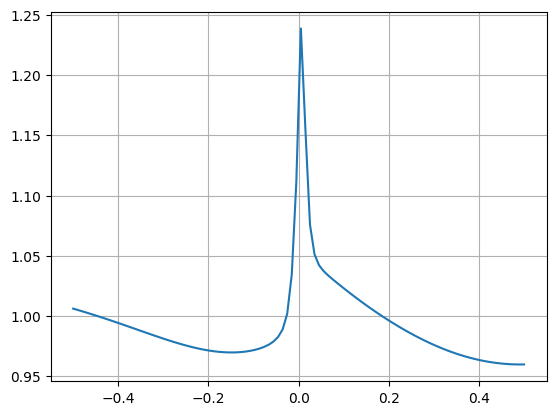

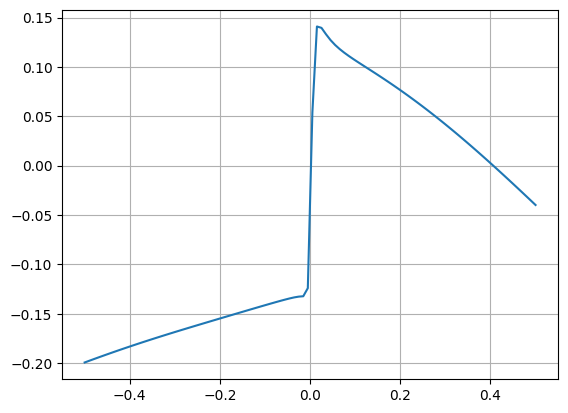

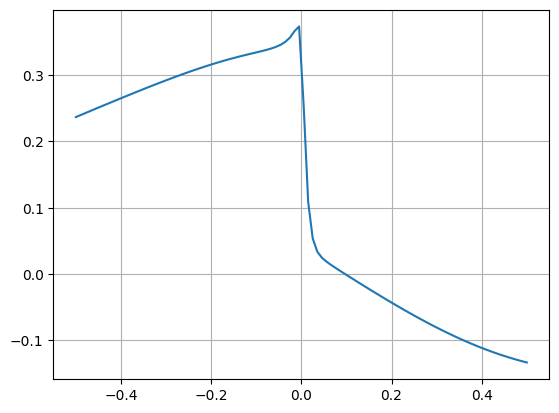

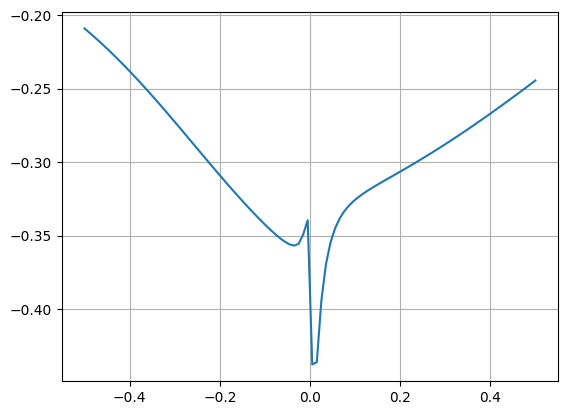

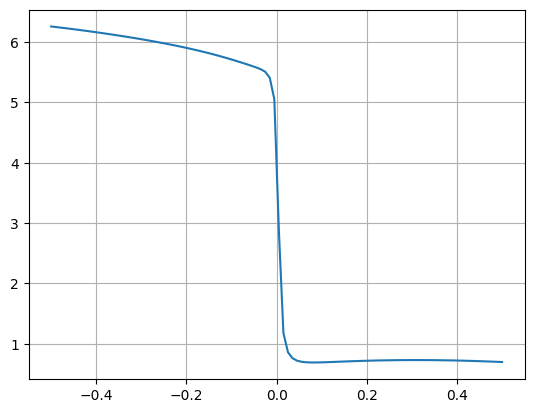

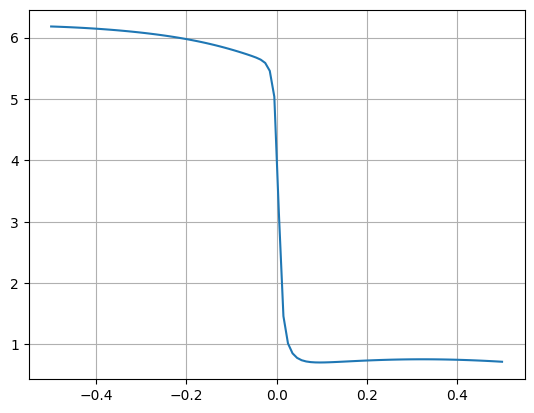

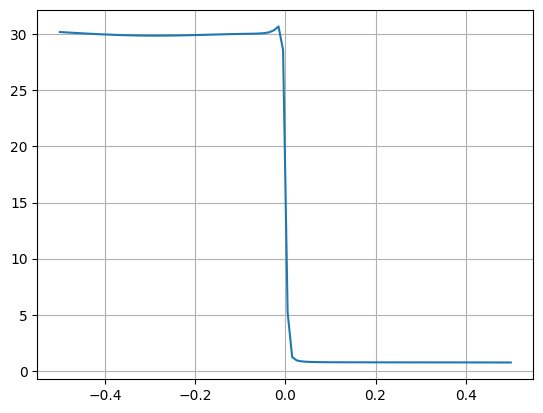

In [10]:
model.eval()

tplot = 0  # 0.147

x = np.linspace(-0.5, 0.5, 100)
t = np.linspace(tplot, tplot, 1)

t, x = np.meshgrid(t, x)
t, x = t.flatten(), x.flatten()
t, x = torch.Tensor(t).to(device), torch.Tensor(x).to(device)
# numeric = inter_condition(tplot, x)
# numeric = numeric.reshape(100, 7)
prediction = model(t, x).detach()
prediction = prediction.reshape(100, 7)

# plt.imshow(prediction)

for i in range(7):

    # plt.plot(x.cpu().numpy(), numeric[:, i].cpu().flatten().numpy())
    plt.plot(x.cpu().numpy(), prediction[:, i].cpu().flatten().numpy())
    plt.grid(True)
    plt.show()

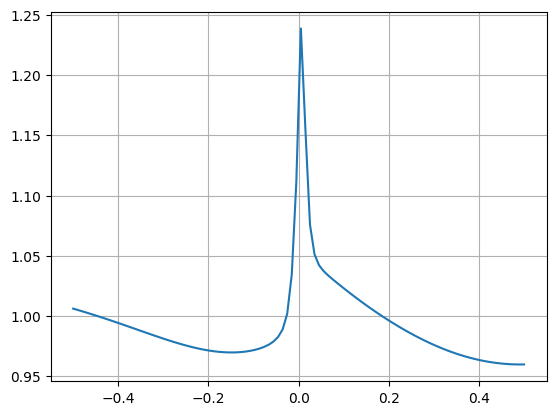

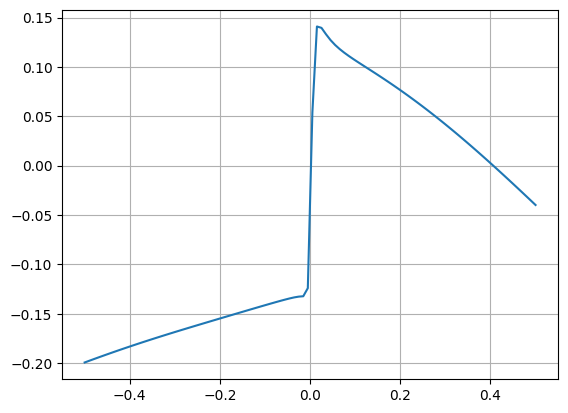

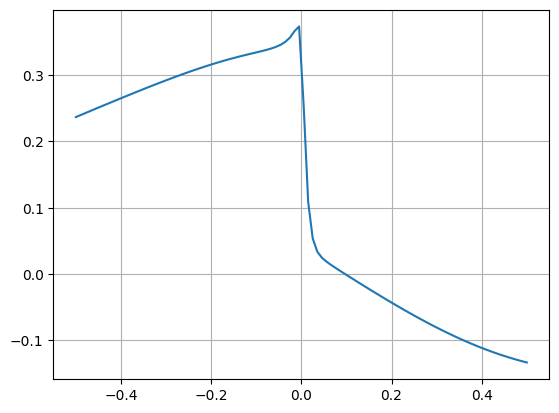

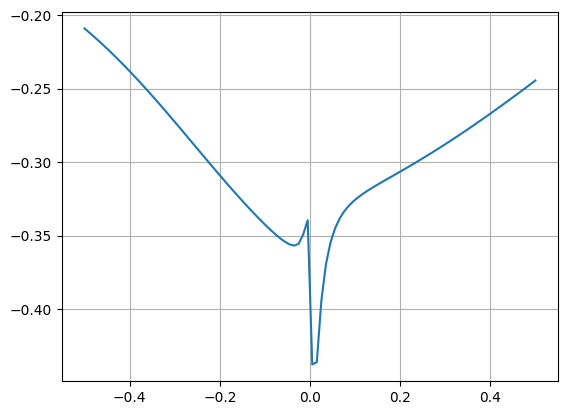

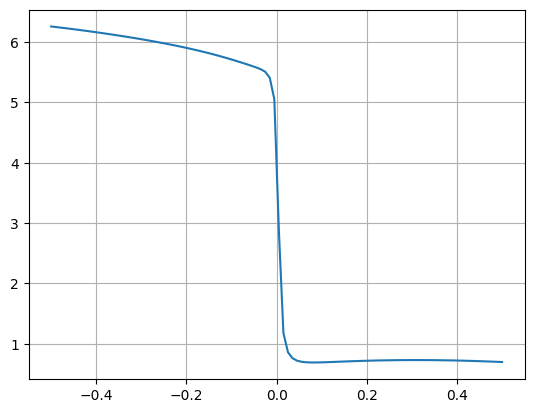

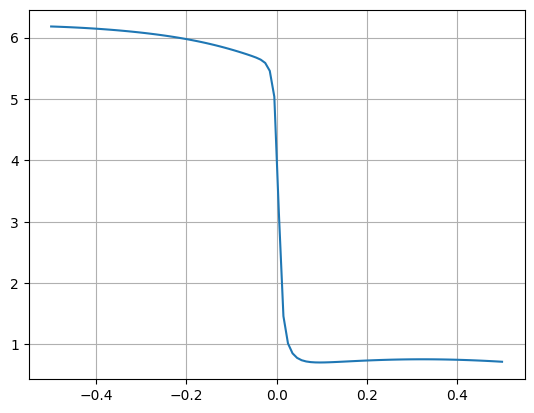

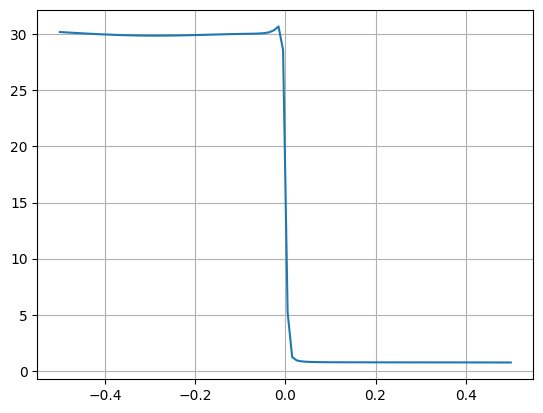

In [11]:
model.eval()

tplot = 0.0 # 0.147

x = np.linspace(-0.5, 0.5, 100)
t = np.linspace(tplot, tplot, 1)

t, x = np.meshgrid(t, x)
t, x = t.flatten(), x.flatten()
t, x = torch.Tensor(t).to(device), torch.Tensor(x).to(device)
# numeric = inter_condition(tplot, x)
# numeric = numeric.reshape(100, 7)
prediction = model(t, x).detach()
prediction = prediction.reshape(100, 7)

# plt.imshow(prediction)

for i in range(7):

    # plt.plot(x.cpu().numpy(), numeric[:, i].cpu().flatten().numpy())
    plt.plot(x.cpu().numpy(), prediction[:, i].cpu().flatten().numpy())
    plt.grid(True)
    plt.show()